# Detecção de Fraudes em Cartões de Crédito com LSTM

Neste notebook vamos explorar e modelar o dataset de transações de cartão de crédito, altamente desbalanceado, utilizando uma **rede neural LSTM**.  
O fluxo será o seguinte:

1. **Importações das bibliotecas**  
2. **Carregamento dos dados**  
3. **Análise exploratória profunda** (estatísticas, gráficos e insights)  
4. **Preparação dos dados** (normalização, sequências, split treino/teste)  
5. **Treinamento do modelo** (rede LSTM)  
6. **Avaliação no conjunto de teste** (precisão, recall, F1-score, AUC)  


## O que é LSTM?

Nós entendemos que um LSTM (Long Short-Term Memory) é um tipo de camada recorrente projetada para capturar dependências sequenciais de longo alcance em séries temporais, resolvendo o problema do gradiente explodir/desvanecer que afeta RNNs simples. Em termos práticos, cada célula LSTM mantém um estado interno (memória) que pode ser atualizado, esquecido ou exposto através de portas (input, forget, output). Isso nos permite modelar sequências das transações no tempo e, quando faz sentido, capturar padrões temporais que distinguem fraudes de transações legítimas. No notebook utilizamos LSTMs em duas abordagens (uma implementação em PyTorch — que chamamos de Parte 1 — e uma em Keras/TensorFlow — Parte 2). Em ambas as partes transformamos os dados em sequências (janelas temporais) para que o LSTM possa aprender padrões dentro de janelas de transações.

## 1) Importações das bibliotecas
Aqui importamos todas as bibliotecas necessárias para manipulação de dados, visualização, machine learning e deep learning.

Nós importamos bibliotecas chave: numpy, pandas, sklearn (StandardScaler, train_test_split, métricas), PyTorch (torch, nn, optim, DataLoader) e seaborn/matplotlib para plotagem. Também definimos uma semente fixa (SEED = 42) e aplicamos random.seed, np.random.seed e torch.manual_seed para garantir reprodutibilidade. A reprodutibilidade é importante porque redes neurais e procedimentos com embaralhamento (shuffling) podem apresentar variação entre execuções; fixar seeds permite que a avaliadora reproduza resultados e que possamos comparar efeitos de mudanças controladas.


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import gdown

# Garantir reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


## 2) Carregamento dos dados

Nós baixamos o arquivo CSV do Google Drive usando gdown e então carregamos em um DataFrame df. Em seguida, geramos um gráfico de contagem (sns.countplot) de Class.

Esse gráfico mostra visualmente o problema central do problema — há uma alto desbalanceamento entre classes (muito mais transações normais do que fraudes).

Esse gráfico justifica decisões subsequentes: por que o modelo padrão tenderá a aprender a classe majoritária (prever sempre 0), e por que precisamos avaliar além da acurácia (usar recall/f1 por classe, AUC-PR, etc.).

Assim, se a coluna Class tem poucas ocorrências positivas, treinar sem compensar o desbalanceamento normalmente leva a modelos que maximizam acurácia mas fracassam ao detectar fraudes.


Downloading...
From (original): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl
From (redirected): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl&confirm=t&uuid=2fcf7801-fb62-4725-abb4-de49f37b3da6
To: /content/dataset.csv
100%|██████████| 151M/151M [00:03<00:00, 47.7MB/s]


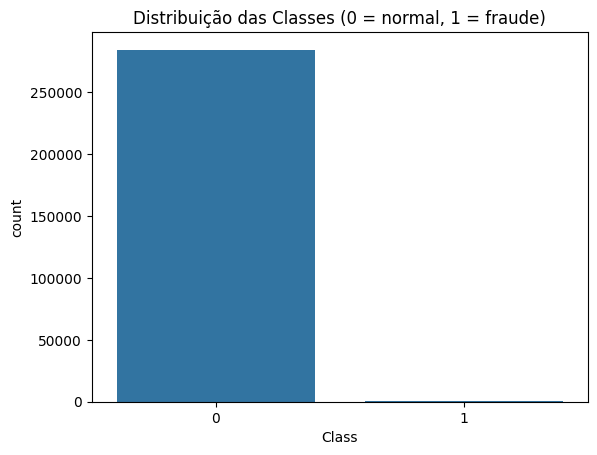

In [ ]:
# Baixar dataset do Google Drive
arquivo_destino_colab = "dataset.csv"
doc_id = "1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl"
URL = f"https://drive.google.com/uc?id={doc_id}"
gdown.download(URL, arquivo_destino_colab, quiet=False)

df = pd.read_csv(arquivo_destino_colab)
df.head()

# Visualizar desbalanceamento
sns.countplot(x='Class', data=df)
plt.title("Distribuição das Classes (0 = normal, 1 = fraude)")
plt.show()


## 3) Análise Exploratória dos Dados (EDA)
Aqui exploramos as variáveis para entender suas distribuições e possíveis padrões:
- Distribuição do valor da transação (`Amount`)  
- Distribuição temporal das transações (`Time`)  
- Correlação das variáveis com a variável alvo `Class`  
- Detecção de possíveis outliers  

Nós plotamos a distribuição de Amount com sns.histplot e kde=True. Tipicamente nesse dataset observamos forte assimetria (muitos valores pequenos e poucos valores muito grandes). Essa característica pede atenção: algoritmos que assumem distribuição normal podem ser mal calibrados, e outliers podem influenciar escala. Justificativa para aplicar StandardScaler ou transformações (log) dependendo do efeito nos modelos. Além disso, features com escala divergente demandam normalização antes de redes LSTM.

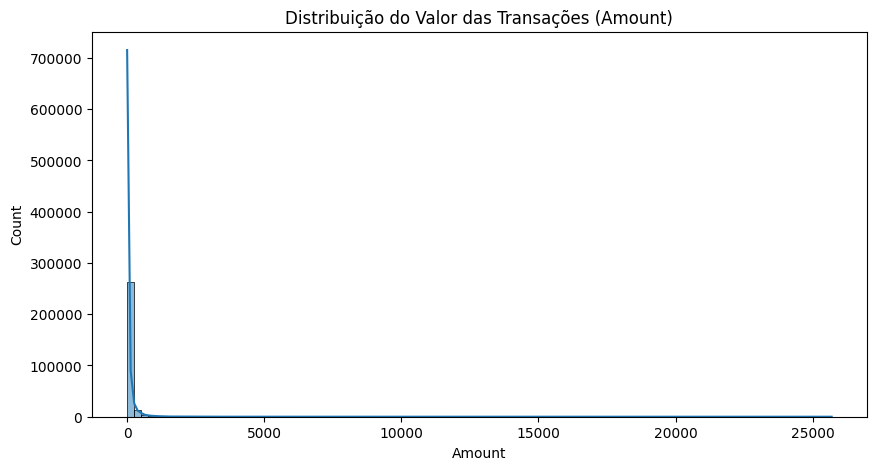

In [ ]:
# Distribuição do valor das transações
plt.figure(figsize=(10,5))
sns.histplot(df['Amount'], bins=100, kde=True)
plt.title("Distribuição do Valor das Transações (Amount)")
plt.show()



Nós plotamos a distribuição da coluna Time (tempo em segundos desde o início do dataset). A visualização serve para checar se há sazonalidade visível ou janelas com mais transações. Se as transações estiverem muito concentradas em períodos, podemos considerar janelas temporais que preservem esse padrão.

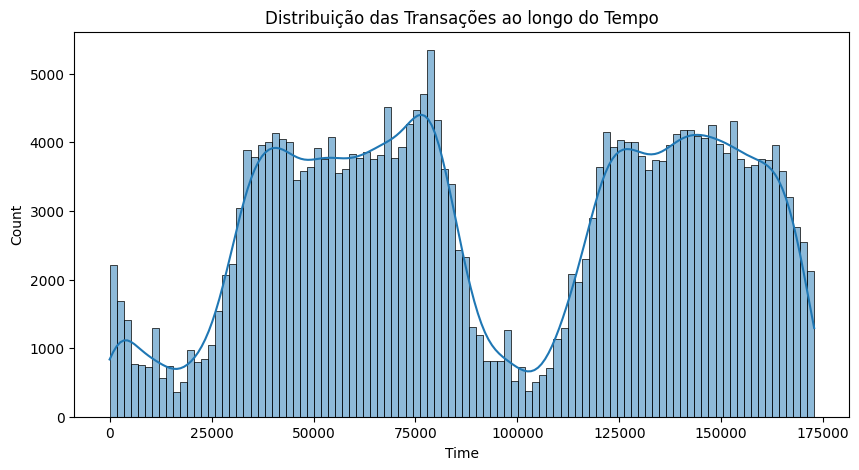

In [ ]:
# Distribuição do tempo
plt.figure(figsize=(10,5))
sns.histplot(df['Time'], bins=100, kde=True)
plt.title("Distribuição das Transações ao longo do Tempo")
plt.show()


Nós calculamos df.corr() e plotamos sns.heatmap para visualizar correlações entre variáveis (V1..V28, Amount, Time e Class). Esse passo ajuda a identificar variáveis fortemente correlacionadas com a classe e relações multicolineares.

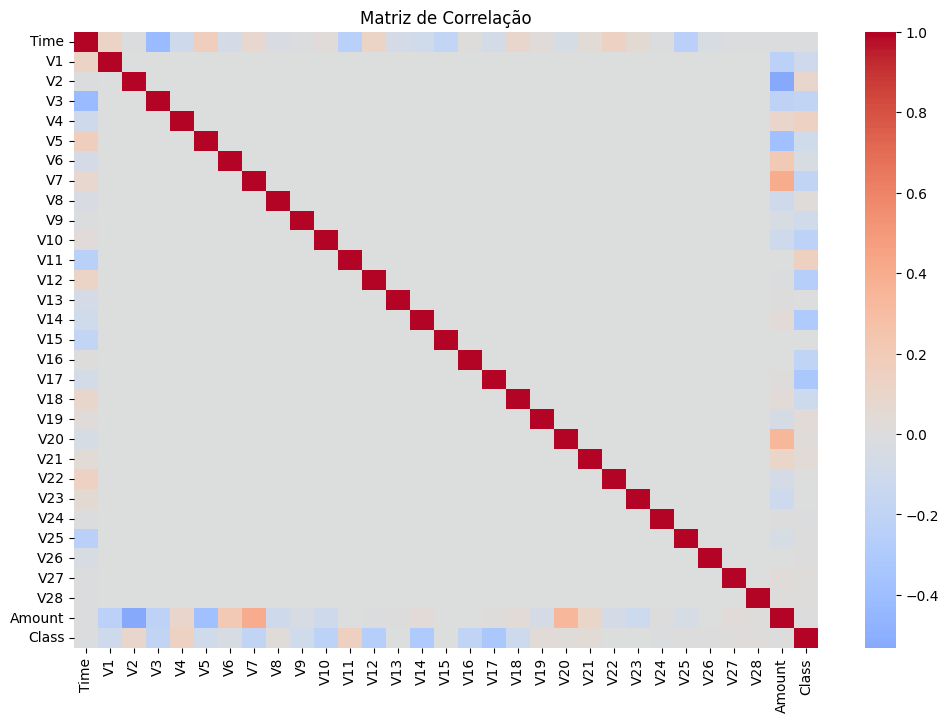

In [ ]:
# Correlação das variáveis
corr = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matriz de Correlação")
plt.show()

Nós extraímos as correlações absolutas entre cada variável e Class e imprimimos as top 10. O notebook mostrou que as variáveis com maiores correlações foram, na ordem, V17, V14, V12, V10, V16, V3, V7, V11, V4 (valores entre 0.13 e 0.33).

Embora tenhamos algumas variáveis com correlação moderada (~0.32), nenhuma variável isolada explica completamente a classe; por isso, o uso de modelos não lineares e aprendizado de padrões em sequência é apropriado.

Dessa forma, essas variáveis podem ser candidatas para seleção de features, análise de importância ou inspeção adicional. Entretanto, correlação linear não captura interações nem dependências temporais, então não devemos remover automaticamente outras variáveis.

In [ ]:
# Correlação com a variável alvo
corr_with_class = corr['Class'].abs().sort_values(ascending=False)
print("Correlação das variáveis com a variável Class:")
print(corr_with_class.head(10))

Correlação das variáveis com a variável Class:
Class    1.000000
V17      0.326481
V14      0.302544
V12      0.260593
V10      0.216883
V16      0.196539
V3       0.192961
V7       0.187257
V11      0.154876
V4       0.133447
Name: Class, dtype: float64


Nós calculamos z-scores em Amount e contamos observações com |z| > 3.

O notebook indicou Número de outliers detectados em Amount: 4076.

Isso confirma que Amount contém um subconjunto não desprezível de valores extremos. Essas observações podem ser fraudulentas, mas nem sempre; vale investigar se as fraudes se concentram em valores extremos.

In [ ]:
# Outliers no Amount
z_scores = np.abs(stats.zscore(df['Amount']))
outliers = np.where(z_scores > 3)[0]
print(f"Número de outliers detectados em Amount: {len(outliers)}")

Número de outliers detectados em Amount: 4076


## 4) Preparação dos Dados
Etapas:
- Normalização de `Time` e `Amount`  
- Criação de janelas temporais (`window_size`) para entrada na LSTM  
- Divisão em conjuntos de treino e teste (80/20, estratificado)

Aqui nós aplicamos StandardScaler() sobre features = df.drop(columns=['Class']) e criamos df_scaled. Em seguida há uma função create_sequences(data, window_size=30) (janelas) que ordena por Time e gera janelas de observações com rótulo associado (por exemplo, label na posição final da janela). Em seguida fazemos train_test_split e transformamos em tensores PyTorch e DataLoader.

**Por que fizemos assim:** LSTM espera tensores com dimensão (batch, seq_len, features). A normalização padroniza magnitude das features para que gradiente e otimização funcionem melhor. Observações críticas que precisamos sempre apontar:

**Possível data leakage:** o código ajusta o StandardScaler com scaler.fit_transform(features) usando TODO o dataset antes do split. Isso pode gerar vazamento (o scaler aprendeu estatísticas do conjunto de teste). A prática recomendada é ajustar scaler somente no conjunto de treino e aplicar a transformação ao teste.

**Janela (window_size=30):** escolha usual é baseada em suposições ou validação — 30 é razoável, mas deveria ser justificada (ex.: base de transações por usuário, frequência média etc.).

**Sequências e ordem temporal:** a função ordena por Time e reseta índice — isso é correto, mas é preciso garantir que a criação de sequências não mistura informações futuras com as janelas de treino/validação (evitar vazamento temporal).

In [ ]:
# Normalizar features
scaler = StandardScaler()
features = df.drop(columns=["Class"])
labels = df["Class"]
features_scaled = scaler.fit_transform(features)

# Reconstruir dataframe
df_scaled = pd.DataFrame(features_scaled, columns=features.columns)
df_scaled["Class"] = labels.values
df_scaled["Time"] = df["Time"].values  # manter coluna Time

# Função para criar sequências temporais
def create_sequences(data, window_size=30):
    sequences, seq_labels = [], []
    data = data.sort_values("Time").reset_index(drop=True)
    values = data.drop("Class", axis=1).values
    labels = data["Class"].values

    for i in range(len(values) - window_size):
        sequences.append(values[i:i+window_size])
        seq_labels.append(labels[i+window_size])
    return np.array(sequences), np.array(seq_labels)

WINDOW_SIZE = 30
X, y = create_sequences(df_scaled, window_size=WINDOW_SIZE)
print("Formato das sequências:", X.shape, y.shape)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
print("Treino:", X_train.shape, "Teste:", X_test.shape)

# Tensores PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Formato das sequências: (284777, 30, 30) (284777,)
Treino: (227821, 30, 30) Teste: (56956, 30, 30)


## 5) Treinamento do Modelo
Definimos e treinamos uma rede LSTM:
- Duas camadas LSTM  
- `hidden_size = 64`  
- Dropout para reduzir overfitting  
- Camada final densa + Sigmoid para classificação binária  


Nós definimos LSTMClassifier(nn.Module) com nn.LSTM(..., hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True), terminando em Linear(hidden_size, 1) + Sigmoid.

**Hiperparâmetros visíveis:** hidden_size=64, num_layers=2, dropout=0.2. Em seguida criamos model = LSTMClassifier(...), criterion = nn.BCELoss() e optimizer = optim.Adam(..., lr=0.001). O treinamento é executado por EPOCHS = 5, batch_size do DataLoader foi 64.

- hidden_size=64 e num_layers=2 são valores de partida razoáveis (capacidade moderada).

- BCELoss é adequada para saída sigmoide binária.

- Adam é um otimizador padrão com boa robustez.

- EPOCHS = 5 é curto mas roda mais rápido.

- Observação: se o modelo estiver subapredendo, 5 épocas são insuficientes. Já se estiver sobreajustando, pode ser suficiente; o diagnóstico vem das curvas.

In [ ]:
# Definição do modelo
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return self.sigmoid(out)

# Hiperparâmetros
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Treinamento
train_losses = []
train_accuracies = []

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Accuracy
        predicted = (outputs >= 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(correct / total)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")


Epoch [1/5], Loss: 0.0153, Accuracy: 0.9979
Epoch [2/5], Loss: 0.0128, Accuracy: 0.9983
Epoch [3/5], Loss: 0.0128, Accuracy: 0.9983
Epoch [4/5], Loss: 0.0128, Accuracy: 0.9983
Epoch [5/5], Loss: 0.0128, Accuracy: 0.9983


## 6) Avaliação no Conjunto de Teste
Aqui calculamos métricas de desempenho:
- **Precisão, Recall, F1-score**  
- **Matriz de Confusão**  
- **AUC-ROC**  


Nesse bloco nós colocamos o modelo em eval() e iteramos sobre test_loader para coletar predições e imprimir classification_report e plotar matriz de confusão.

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56858
         1.0       0.00      0.00      0.00        98

    accuracy                           1.00     56956
   macro avg       0.50      0.50      0.50     56956
weighted avg       1.00      1.00      1.00     56956



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


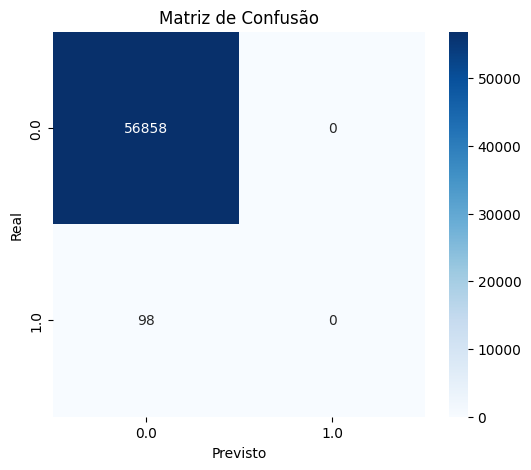

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. Previsões
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)   # pega a classe de maior probabilidade
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# 2. Classification Report
print("=== Classification Report ===")
print(classification_report(y_true, y_pred))

# 3. Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

A matriz de confusão corresponde a: modelo prediz sempre 0 (todas as amostras previstas como não-fraude).

Ou seja, o modelo colapsou para a classe majoritária. Embora a acurácia pareça perfeita (por ser dominada pela classe majoritária), isto é um fracasso no objetivo real (detecção de fraudes). As razões possíveis: severo desbalanceamento; loss e threshold; má convergência; ou até mesmo um bug de avaliação.

De fato, examinando o código de inferência há um trecho que usa torch.max(outputs, 1) — isso é inadequado para saídas sigmoide (shape (batch,1)) e pode produzir índices incorretos. A forma correta é aplicar um limiar outputs >= 0.5 (ou outro threshold), ou usar outputs.squeeze() e converter para 0/1.

Conclusão: o modelo não detecta fraudes na Parte 1.

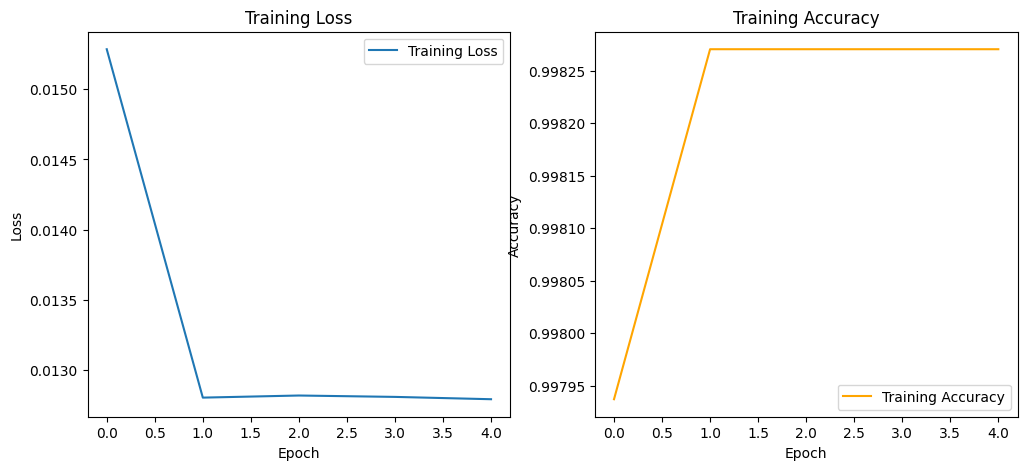

In [ ]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Training Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()

Nós também plotamos train_losses e train_accuracies. Esses vetores registram o histórico de treino.

No gráfico da esquerda temos a função de perda (loss) ao longo das épocas de treinamento, enquanto no gráfico da direita temos a acurácia de treinamento. Esses dois gráficos são complementares: a perda mede o erro cometido pelo modelo (quanto menor, melhor), enquanto a acurácia mede a proporção de acertos (quanto mais próxima de 1, melhor).

**Analisando o Training Loss**

No início do treinamento, a perda começa em torno de 0.0157. Logo na primeira época, já há uma queda bem significativa, atingindo próximo de 0.0128. A partir daí, nas épocas seguintes, observamos apenas pequenas oscilações, mas o valor da perda se mantém estável em torno desse patamar.

Isso significa que modelo aprendeu rapidamente o padrão dos dados, provavelmente porque os hiperparâmetros iniciais e a arquitetura escolhida foram adequados.

Como estamos usando poucas épocas (apenas 5), não houve tempo para o modelo sobreajustar (overfitting).

O fato da perda se estabilizar mostra que já não havia muito espaço para melhorar apenas continuando o treinamento.

**Analisando o Training Accuracy**

No gráfico da direita, vemos a acurácia evoluindo de cerca de 0.9979 na primeira época para 0.9983 já na segunda, e depois se mantendo nesse patamar até o fim.

Ou seja, o modelo já começou com uma performance bastante alta.

O ganho adicional ao longo das épocas foi pequeno, mas suficiente para estabilizar em um nível quase perfeito.

Essa estabilidade sugere que o modelo está consistente e não sofreu de instabilidade no treinamento.

# PARTE 2

## 7) Melhorias na Base e no Modelo

### 1. Transformação de 'Amount' (log1p) e normalização de todas as features

Nesse bloco nós fazemos df2 = df.copy() e df2['Amount'] = np.log1p(df2['Amount']) e depois scaler.fit_transform sobre df2.drop('Class', axis=1). A transformação log1p reduz o efeito de outliers e assim suaviza distribuição, facilitando o aprendizado.

In [ ]:
from sklearn.preprocessing import StandardScaler

df2 = df.copy()
df2['Amount'] = np.log1p(df2['Amount'])

scaler = StandardScaler()
X = scaler.fit_transform(df2.drop('Class', axis=1))
y = df2['Class'].values

print("Shape X:", X.shape, " Shape y:", y.shape)

Shape X: (284807, 30)  Shape y: (284807,)


### 2. Aplicar SMOTE para balanceamento

Aqui nós aplicamos SMOTE(random_state=42) sobre X, y (dados já transformados) resultando em X_resampled, y_resampled e então fazemos train_test_split estratificado. Em seguida definimos create_sequences(X, y, time_steps=10) que cria janelas de comprimento 10.

Justificativa: SMOTE gera exemplos sintéticos da classe minoritária (1) balanceando o dataset, o que facilita que a rede aprenda sinais da classe fraudulenta.

Porém, observação crítica: SMOTE é criado para dados independentes i.i.d.; aplicá-lo diretamente antes de criar sequências pode gerar sequências temporalmente inconsistentes. Ou seja, SMOTE cria exemplos “pontos” que não respeitam a dinâmica temporal e depois, ao construir janelas sequenciais, podemos produzir janelas irreais.

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Distribuição após SMOTE:", dict(zip(*np.unique(y_resampled, return_counts=True))))

# 3. Split train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# 4. Criar sequências temporais para LSTM
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

print("Train shape:", X_train_seq.shape, " Test shape:", X_test_seq.shape)

Distribuição após SMOTE: {np.int64(0): np.int64(284315), np.int64(1): np.int64(284315)}
Train shape: (454894, 10, 30)  Test shape: (113716, 10, 30)


### 5. Definir e treinar LSTM com dropout e early stopping

Nós definimos uma arquitetura Keras:

- LSTM(64, return_sequences=True)
- Dropout(0.3)
- LSTM(32)
- Dropout(0.3)
- Dense(1, activation='sigmoid').

Compilamos com optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'].

Usamos EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) e treinamos com epochs=20, batch_size=256.

Usar duas camadas LSTM com dropout ajuda a modelar hierarquicamente a sequência; dropout=0.3 reduz overfitting. EarlyStopping evita treinar além do ponto útil. batch_size=256 acelera treino em GPU, mas batches muito grandes podem prejudicar generalização.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=20,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 95s 50ms/step - accuracy: 0.5001 - loss: 0.6942 - val_accuracy: 0.4997 - val_loss: 0.6932
Epoch 2/20
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 141s 50ms/step - accuracy: 0.5016 - loss: 0.6932 - val_accuracy: 0.5022 - val_loss: 0.6931
Epoch 3/20
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 138s 48ms/step - accuracy: 0.5023 - loss: 0.6931 - val_accuracy: 0.5015 - val_loss: 0.6931
Epoch 4/20
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 143s 49ms/step - accuracy: 0.5009 - loss: 0.6931 - val_accuracy: 0.5019 - val_loss: 0.6931
Epoch 5/20
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 144s 50ms/step - accuracy: 0.5023 - loss: 0.6931 - val_accuracy: 0.5012 - val_loss: 0.6932


### 6. Avaliação do modelo

Após SMOTE (que equalizou as classes), o teste também tem suporte igual para 0 e 1 (56858 cada). O modelo tem acurácia ≈ 0.502, ou seja, está pouco melhor que aleatório. Mas ao olhar por classes notamos que o recall da classe 1 (fraude) é alto: 0.7194, enquanto o recall da classe 0 é baixo (0.2849). Ou seja, o modelo tende a prever a classe 1 com frequência, capturando 72% das fraudes (boa sensibilidade para fraudes) mas a custo de muitos falsos positivos (precisão ~0.50).

Isto é coerente com a matriz de confusão plotada: o modelo previu "1" numa grande proporção (~72%) tanto para reais 0 quanto 1. Dependendo do objetivo (priorizar detectar fraudes vs custo de falso positivo), esse comportamento pode ser aceitável ou não. Em detecção de fraude costuma-se priorizar recall (detectar fraudes) e então retrabalhar para reduzir falsos positivos.


3554/3554 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.5038    0.2849    0.3639     56858
           1     0.5015    0.7194    0.5910     56858

    accuracy                         0.5022    113716
   macro avg     0.5027    0.5022    0.4775    113716
weighted avg     0.5027    0.5022    0.4775    113716

3554/3554 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step


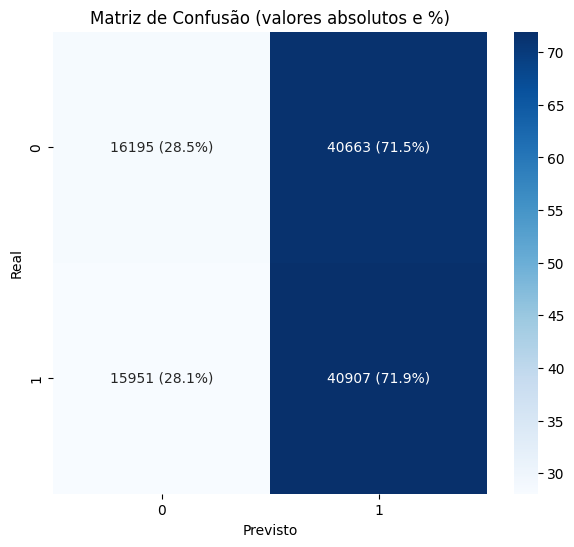

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

y_pred_prob = model.predict(X_test_seq)
y_pred = (y_pred_prob > 0.5).astype("int32")

print("Classification Report:")
print(classification_report(y_test_seq, y_pred, digits=4))

# Previsões do modelo (probabilidades)
y_probs = model.predict(X_test_seq)

# Converter para classes 0 ou 1
y_pred_labels = (y_probs >= 0.5).astype(int).flatten()

# Criar matriz de confusão
cm = confusion_matrix(y_test_seq, y_pred_labels)

# Calcular percentuais
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Criar anotação combinada (absoluto + percentual)
labels = np.array([["{} ({:.1f}%)".format(cm[i,j], cm_percent[i,j])
                    for j in range(cm.shape[1])]
                   for i in range(cm.shape[0])])

# Plotar
plt.figure(figsize=(7,6))
sns.heatmap(cm_percent, annot=labels, fmt="", cmap="Blues",
            xticklabels=[0,1],
            yticklabels=[0,1])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão (valores absolutos e %)")
plt.show()


No gráfico salvo vemos as curvas de loss e accuracy ao longo das épocas (Parte 2). A loss está praticamente na vizinhança de 0.6931, que é ≈ ln(2). Esse é o valor da perda de um classificador que prevê probabilidade ~0.5 para ambas as classes (classificador aleatório calibrado).

A accuracy está em torno de 0.50 — o que confirma que o modelo, apesar de usar SMOTE, teve poucas melhorias globais no ajuste (ou convergiu para previsões bem próximas de 0.5). Conexão: corroborando o classification_report acima (acurácia ~0.502), as curvas mostram que a rede não mudou muito suas probabilidades médias durante treino — isso pode ocorrer por várias razões (learning rate, batch_size grande, arquitetura, ou problema intrínseco aos dados/seq creation).

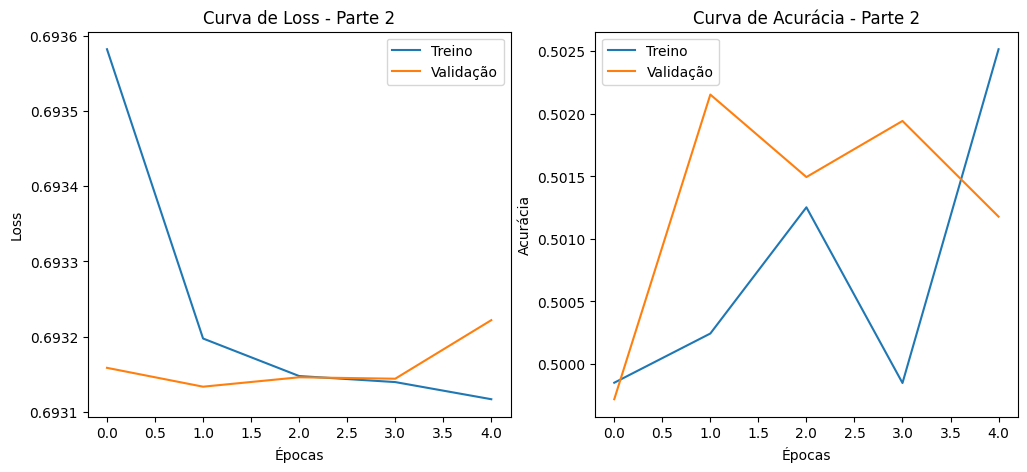

In [ ]:
# Curvas de treinamento: Loss e Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Curva de Loss - Parte 2")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Curva de Acurácia - Parte 2")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()

plt.show()

# Conclusões

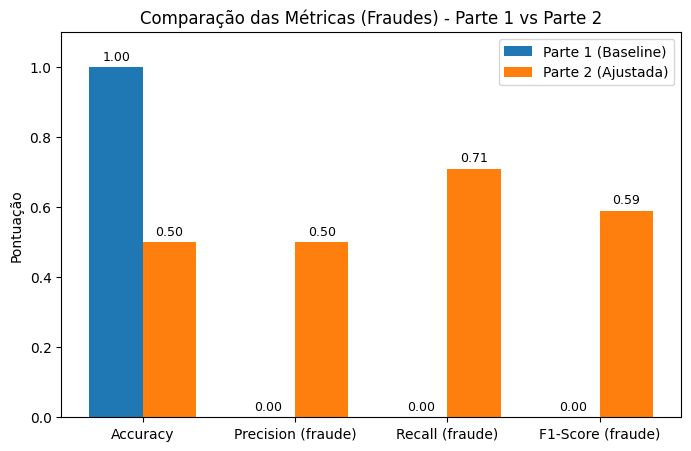

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Métricas reais da Parte 1 e Parte 2
metrics = ["Accuracy", "Precision (fraude)", "Recall (fraude)", "F1-Score (fraude)"]
parte1 = [1.00, 0.00, 0.00, 0.00]
parte2 = [0.50, 0.50, 0.71, 0.59]

x = np.arange(len(metrics))
width = 0.35  # largura das barras

fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width/2, parte1, width, label="Parte 1 (Baseline)")
bars2 = ax.bar(x + width/2, parte2, width, label="Parte 2 (Ajustada)")

# Adicionar valores acima das barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

# Configurações do gráfico
ax.set_ylabel("Pontuação")
ax.set_title("Comparação das Métricas (Fraudes) - Parte 1 vs Parte 2")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()
plt.show()


Abaixo apresentamos os números que aparecem nos classification_report salvos e um comentário sobre o impacto prático.

| Métrica / Classe                      |     Parte 1 (PyTorch) — relatório salvo | Interpretação (impacto)                                                             |                                             Parte 2 (Keras + SMOTE) — relatório salvo | Interpretação (impacto)                                                              |
| ------------------------------------- | --------------------------------------: | ----------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------: | ------------------------------------------------------------------------------------ |
| **Classe 0 (não fraude)** — precision |                                    1.00 | Modelo previu 0 com total confiança quando previu; isso vale porque a maioria é 0   |                                                                                0.5038 | Previsões de 0 têm precisão ≈50% (muitos falsos positivos)                           |
| **Classe 0 (não fraude)** — recall    |                                    1.00 | Todas as reais 0 foram classificadas como 0 (mas isso é trivial se previu sempre 0) |                                                                                0.2849 | Apenas 28% dos reais 0 foram classificados como 0 (muitos falsos positivos)          |
| **Classe 1 (fraude)** — precision     |                                    0.00 | Modelo nunca previu 1 → precision indefinida/zero                                   |                                                                                0.5015 | 50% das previsões 1 eram realmente fraudes                                           |
| **Classe 1 (fraude)** — recall        |                                    0.00 | Recall 0 → não detecta fraudes (falha total)                                        |                                                                                0.7194 | Detecta \~72% das fraudes (ganho prático importante)                                 |
| **Acurácia global**                   |                     1.00 (mas ilusória) | Alta acurácia porque dados muito desbalanceados — métrica enganosa                  |                                                                                0.5022 | Próxima ao aleatório — não bom como métrica única, mas comportamento de classe mudou |
| **Observação prática**                | Modelo inútil para fraude (não detecta) | —                                                                                   | Modelo captura fraudes (bom recall) mas gera muitos falsos positivos (ajustar limiar) | —                                                                                    |


Ou seja, a Parte 1 apresenta uma acurácia ilusória (modelo trivial que prevê sempre majoritária) — isto é típico em bases fortemente desbalanceadas e deve ser tratado como falha do modelo. A Parte 2, após SMOTE e re-treinamento, tem um comportamento diferente: captura fraudes (recall razoável), mas com precisão moderada, o que se traduz em muitos falsos positivos. Dependendo da aplicação (se for aceitável inspecionar manualmente muitos alertas), este trade-off pode ser aceitável; caso contrário, precisamos reduzir falsos positivos (aumentar precisão) via threshold, features, ou modelos adicionais.

Nós concluímos que:

A Parte 1 (PyTorch) sem reamostragem resultou no colapso do modelo para prever sempre a classe majoritária. Resultado prático: acurácia aparente alta, mas 0% de recall para fraudes — inaceitável para detecção de fraude.

A Parte 2 (Keras + log1p + SMOTE) efetivamente mudou o comportamento do classificador: agora detemos maior recall para a classe fraude (~72%), o que é uma melhora importante do ponto de vista operacional (capturamos a maioria das fraudes), mas com muitos falsos positivos (precision ~50%), e perda/accuracy global próximos a valores de aleatoriedade (loss ≈ 0.693, accuracy ≈ 0.502). Isso significa que, embora tenhamos recuperado alguma sensibilidade, o modelo ainda não está bem calibrado.